In [1]:
import numpy as np
d = np.load("../runs/dataset.npz")

X_train, y_train = d["X_train"], d["y_train"]
X_val, y_val     = d["X_val"], d["y_val"]
X_test, y_test   = d["X_test"], d["y_test"]

X_train.shape, y_train.shape


((1452621, 60, 1), (1452621, 1))

In [7]:
import os, sys
sys.path.append(os.path.abspath(".."))

import tensorflow as tf
from src.model_lstm import build_lstm

os.makedirs("../runs/models", exist_ok=True)

model = build_lstm(input_shape=X_train.shape[1:], units=64, dropout=0.2, lr=1e-3)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("../runs/models/lstm_best.keras", monitor="val_loss", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=callbacks
)


I0000 00:00:1765787000.061013   12984 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38435 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 3g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Epoch 1/50


2025-12-15 08:23:22.959538: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


5675/5675 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 7.3458e-04 - mae: 0.0119 - val_loss: 4.9737e-04 - val_mae: 0.0085
Epoch 2/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.4449e-04 - mae: 0.0110 - val_loss: 4.8803e-04 - val_mae: 0.0081
Epoch 3/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3951e-04 - mae: 0.0109 - val_loss: 4.9439e-04 - val_mae: 0.0087
Epoch 4/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3690e-04 - mae: 0.0109 - val_loss: 4.8617e-04 - val_mae: 0.0088
Epoch 5/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3452e-04 - mae: 0.0109 - val_loss: 4.8462e-04 - val_mae: 0.0081
Epoch 6/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3251e-04 - mae: 0.0108 - val_loss: 4.8399e-04 - val_mae: 0.0085
Epoch 7/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3035e-04 - mae: 0.0108 - val_loss: 4.8327e-04 - val_mae: 0.0080
Epoch 8/50
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 6.3039e-04 - mae: 0.0108 - val_loss: 4.8232e-

In [11]:
import joblib
import numpy as np

scaler = joblib.load("../runs/minmax_scaler.pkl")

y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test)

y_pred[:5].ravel(), y_true[:5].ravel()


9726/9726 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step


(array([2.466381 , 3.4711661, 3.35429  , 3.2851474, 2.8814042],
       dtype=float32),
 array([3.546, 3.666, 3.508, 3.012, 2.72 ]))

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae, rmse


(0.07465251790147467, np.float64(0.20334047842760705))

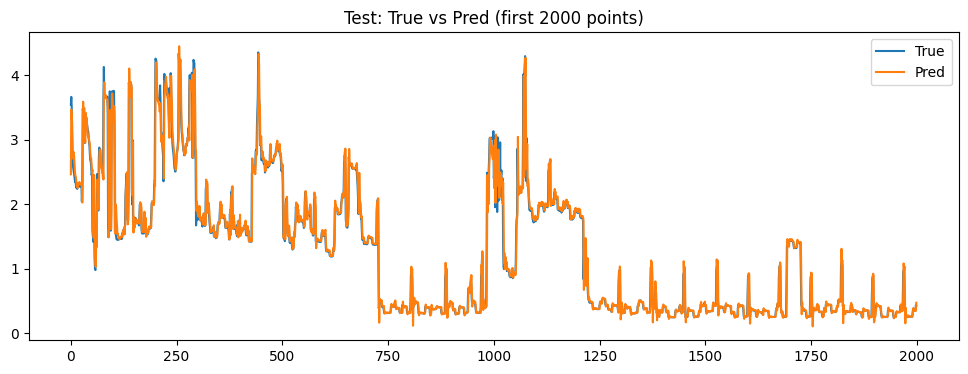

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_true[:2000], label="True")
plt.plot(y_pred[:2000], label="Pred")
plt.legend()
plt.title("Test: True vs Pred (first 2000 points)")
plt.show()


In [14]:
import pandas as pd

df = pd.read_csv("../data/processed/power_1min.csv",
                 parse_dates=["Datetime"], index_col="Datetime").sort_index()

n = len(df)
train_end = int(n * 0.7)
val_end   = int(n * 0.85)
test_df = df.iloc[val_end:].copy()

# 윈도우에서 y는 lookback 이후 시점부터 생김
LOOKBACK = X_test.shape[1]   # 60일 가능성 높음
HORIZON  = 1

y_time_index = test_df.index[LOOKBACK + HORIZON - 1 : ]  # y_test 길이와 맞아야 함

print("len(y_time_index):", len(y_time_index))
print("len(y_test):", len(y_test))


len(y_time_index): 311229
len(y_test): 311229


In [15]:
peak_mask = (y_time_index.hour >= 18) & (y_time_index.hour < 22)
nonpeak_mask = ~peak_mask

def metrics(y_t, y_p):
    mae  = mean_absolute_error(y_t, y_p)
    rmse = np.sqrt(mean_squared_error(y_t, y_p))
    mape = np.mean(np.abs((y_t - y_p) / (y_t + 1e-9))) * 100
    return mae, rmse, mape

all_mae, all_rmse, all_mape = metrics(y_true, y_pred)
peak_mae, peak_rmse, peak_mape = metrics(y_true[peak_mask], y_pred[peak_mask])
non_mae, non_rmse, non_mape = metrics(y_true[nonpeak_mask], y_pred[nonpeak_mask])

print("ALL     | MAE/RMSE/MAPE:", all_mae, all_rmse, all_mape)
print("PEAK    | MAE/RMSE/MAPE:", peak_mae, peak_rmse, peak_mape)
print("NONPEAK | MAE/RMSE/MAPE:", non_mae, non_rmse, non_mape)

# 결과 저장
out = pd.DataFrame([
    ["ALL", all_mae, all_rmse, all_mape],
    ["PEAK(18-22)", peak_mae, peak_rmse, peak_mape],
    ["NONPEAK", non_mae, non_rmse, non_mape],
], columns=["segment","MAE","RMSE","MAPE(%)"])

out.to_csv("../runs/metrics_by_segment.csv", index=False)
out


ALL     | MAE/RMSE/MAPE: 0.07465251790147467 0.20334047842760705 8.53825607110244
PEAK    | MAE/RMSE/MAPE: 0.10958797684707658 0.26665492186798917 8.780786294994126
NONPEAK | MAE/RMSE/MAPE: 0.0676409233368155 0.18808237459835142 8.489579922257438


,segment,MAE,RMSE,MAPE(%)
0,ALL,0.074653,0.203340,8.538256
1,PEAK(18-22),0.109588,0.266655,8.780786
2,NONPEAK,0.067641,0.188082,8.489580


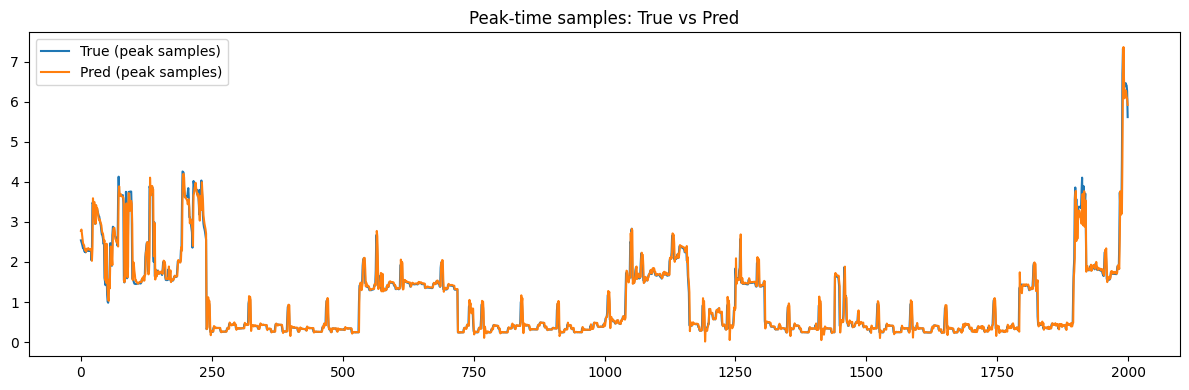

In [18]:
import os
os.makedirs("../runs/figures", exist_ok=True)

import numpy as np
import matplotlib.pyplot as plt


peak_idx = np.where(peak_mask)[0]

K = 2000  # 피크 샘플 중 앞 K개
sel = peak_idx[:K]

plt.figure(figsize=(12,4))
plt.plot(y_true[sel], label="True (peak samples)")
plt.plot(y_pred[sel], label="Pred (peak samples)")
plt.legend()
plt.title("Peak-time samples: True vs Pred")
plt.tight_layout()
plt.savefig("../runs/figures/peak_samples_true_vs_pred.png", dpi=200)
plt.show()